In [15]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter
from time import sleep
import json
import random

In [2]:
with open('data/pos_train.json') as json_data:
    d = json.load(json_data)

text=[]
l=0

for i in d:
    for j in i:
        for k in j:
            text.append(k)

tt = []
for i in range(len(text)):
    if(text[i]!=''):
        tt.append(text[i])

text = tt

for i in range(len(text)):
    if(text[i]=='$'or text[i]=='PDT' or text[i]=='WP$' or text[i]=="SYM" or text[i]=='LS' or text[i]=='#' or text[i]=='UH'):
        text[i]='OTHER'
    

word_counts = Counter(text)

word_counts.most_common()

[('NN', 391092),
 ('IN', 313428),
 ('NNP', 286327),
 ('DT', 246818),
 ('JJ', 194522),
 ('NNS', 150057),
 (',', 138811),
 ('.', 92716),
 ('CC', 86433),
 ('VBD', 83807),
 ('CD', 77651),
 ('RB', 71899),
 ('VBN', 69596),
 ('TO', 48800),
 ('VBZ', 41862),
 ('VB', 40118),
 ('VBG', 35283),
 (':', 34343),
 ('VBP', 28324),
 ('PRP', 24380),
 ('FW', 22213),
 ('PRP$', 18771),
 ('POS', 14923),
 ('WDT', 13756),
 ("''", 13344),
 ('``', 12561),
 ('MD', 11441),
 ('NNPS', 10637),
 ('JJS', 6400),
 ('JJR', 6373),
 ('WRB', 5119),
 ('WP', 4378),
 ('RP', 3189),
 ('RBR', 2910),
 ('OTHER', 2645),
 ('EX', 2623),
 ('RBS', 2274)]

In [3]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [4]:
words = text

print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

# vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

Total words: 2609824
Unique words: 37


In [5]:
def get_train_word():
    threshold = random.uniform(0.06, 0.09)
    word_counts = Counter(int_words)
    total_count = len(int_words)
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
    return train_words, threshold

In [6]:
batch_size = 1000
window_size = 2
n_vocab = len(int_to_vocab)
n_embedding =  50

In [7]:
with tf.device('/device:GPU:1'):

    train_graph = tf.Graph()
    with train_graph.as_default():
        inputs = tf.placeholder(tf.int32, [None], name='inputs')
        labels = tf.placeholder(tf.int32, [None, None], name='labels')
        
        embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
        embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output
        
        softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # create softmax weight matrix here
        softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here
        
        logits = tf.matmul(embed, tf.transpose(softmax_w)) + softmax_b
        labels_one_hot = tf.one_hot(labels, n_vocab)

        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits)
        cost = tf.reduce_mean(loss)
        
        global_step = tf.Variable(0, trainable=False, name="global_step")

        optimizer = tf.train.AdamOptimizer().minimize(cost, global_step=global_step)
        
         ## From Thushan Ganegedara's implementation
        valid_size = 16 # Random set of words to evaluate similarity on.
        valid_window = n_vocab
        # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
        valid_examples = np.array(random.sample(range(valid_window), valid_size))
#                                    random.sample(range(1000,1000+valid_window), valid_size//2))

        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        normalized_embedding = embedding / norm
        valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
        similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [8]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints/pos

mkdir: cannot create directory ‘checkpoints/pos’: File exists


In [9]:
epochs = 50

In [12]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints/pos'))
#     embed_mat = sess.run(embedding)
    
    for e in range(1, epochs+1):
        train_words, threshold = get_train_word()
        print("Epoch {}/{}".format(e, epochs), "Threshold: {}".format(threshold), "Length of Training words: {}".format(len(train_words)))
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            global_steps, train_loss, _ = sess.run([global_step, cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100== 0: 
                end = time.time()
                print("Global Step: {}".format(global_steps), "Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/pos/pos.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/50 Threshold: 0.08708670843710356 Length of Training words: 2429632
Global Step: 100 Epoch 1/50 Iteration: 100 Avg. Training loss: 6.8498 0.0283 sec/batch
Global Step: 200 Epoch 1/50 Iteration: 200 Avg. Training loss: 4.8515 0.0158 sec/batch
Global Step: 300 Epoch 1/50 Iteration: 300 Avg. Training loss: 3.8954 0.0156 sec/batch
Global Step: 400 Epoch 1/50 Iteration: 400 Avg. Training loss: 3.4002 0.0161 sec/batch
Global Step: 500 Epoch 1/50 Iteration: 500 Avg. Training loss: 3.1780 0.0152 sec/batch
Global Step: 600 Epoch 1/50 Iteration: 600 Avg. Training loss: 3.0604 0.0136 sec/batch
Global Step: 700 Epoch 1/50 Iteration: 700 Avg. Training loss: 2.9929 0.0124 sec/batch
Global Step: 800 Epoch 1/50 Iteration: 800 Avg. Training loss: 2.9768 0.0178 sec/batch
Global Step: 900 Epoch 1/50 Iteration: 900 Avg. Training loss: 2.9223 0.0158 sec/batch
Global Step: 1000 Epoch 1/50 Iteration: 1000 Avg. Training loss: 2.8990 0.0155 sec/batch
Global Step: 1100 Epoch 1/50 Iteration: 1100 Avg. Tr

Global Step: 9000 Epoch 4/50 Iteration: 9000 Avg. Training loss: 2.8367 0.0152 sec/batch
Global Step: 9100 Epoch 4/50 Iteration: 9100 Avg. Training loss: 2.8509 0.0162 sec/batch
Global Step: 9200 Epoch 4/50 Iteration: 9200 Avg. Training loss: 2.8298 0.0165 sec/batch
Global Step: 9300 Epoch 4/50 Iteration: 9300 Avg. Training loss: 2.8201 0.0155 sec/batch
Global Step: 9400 Epoch 4/50 Iteration: 9400 Avg. Training loss: 2.8320 0.0141 sec/batch
Global Step: 9500 Epoch 4/50 Iteration: 9500 Avg. Training loss: 2.8372 0.0174 sec/batch
Epoch 5/50 Threshold: 0.0848752245043963 Length of Training words: 2415331
Global Step: 9600 Epoch 5/50 Iteration: 9600 Avg. Training loss: 2.8358 0.0085 sec/batch
Global Step: 9700 Epoch 5/50 Iteration: 9700 Avg. Training loss: 2.8597 0.0174 sec/batch
Global Step: 9800 Epoch 5/50 Iteration: 9800 Avg. Training loss: 2.8593 0.0166 sec/batch
Global Step: 9900 Epoch 5/50 Iteration: 9900 Avg. Training loss: 2.8449 0.0134 sec/batch
Global Step: 10000 Epoch 5/50 Itera

Global Step: 17700 Epoch 8/50 Iteration: 17700 Avg. Training loss: 2.8237 0.0144 sec/batch
Global Step: 17800 Epoch 8/50 Iteration: 17800 Avg. Training loss: 2.8300 0.0127 sec/batch
Global Step: 17900 Epoch 8/50 Iteration: 17900 Avg. Training loss: 2.8458 0.0158 sec/batch
Global Step: 18000 Epoch 8/50 Iteration: 18000 Avg. Training loss: 2.8464 0.0136 sec/batch
Global Step: 18100 Epoch 8/50 Iteration: 18100 Avg. Training loss: 2.8346 0.0166 sec/batch
Global Step: 18200 Epoch 8/50 Iteration: 18200 Avg. Training loss: 2.8472 0.0168 sec/batch
Global Step: 18300 Epoch 8/50 Iteration: 18300 Avg. Training loss: 2.8252 0.0158 sec/batch
Global Step: 18400 Epoch 8/50 Iteration: 18400 Avg. Training loss: 2.8632 0.0176 sec/batch
Global Step: 18500 Epoch 8/50 Iteration: 18500 Avg. Training loss: 2.8403 0.0161 sec/batch
Global Step: 18600 Epoch 8/50 Iteration: 18600 Avg. Training loss: 2.8588 0.0135 sec/batch
Global Step: 18700 Epoch 8/50 Iteration: 18700 Avg. Training loss: 2.8214 0.0137 sec/batch

Epoch 12/50 Threshold: 0.08110778818964093 Length of Training words: 2392894
Global Step: 26400 Epoch 12/50 Iteration: 26400 Avg. Training loss: 2.8435 0.0091 sec/batch
Global Step: 26500 Epoch 12/50 Iteration: 26500 Avg. Training loss: 2.8679 0.0172 sec/batch
Global Step: 26600 Epoch 12/50 Iteration: 26600 Avg. Training loss: 2.8693 0.0159 sec/batch
Global Step: 26700 Epoch 12/50 Iteration: 26700 Avg. Training loss: 2.8375 0.0153 sec/batch
Global Step: 26800 Epoch 12/50 Iteration: 26800 Avg. Training loss: 2.8435 0.0164 sec/batch
Global Step: 26900 Epoch 12/50 Iteration: 26900 Avg. Training loss: 2.8369 0.0145 sec/batch
Global Step: 27000 Epoch 12/50 Iteration: 27000 Avg. Training loss: 2.8479 0.0164 sec/batch
Global Step: 27100 Epoch 12/50 Iteration: 27100 Avg. Training loss: 2.8547 0.0155 sec/batch
Global Step: 27200 Epoch 12/50 Iteration: 27200 Avg. Training loss: 2.8543 0.0150 sec/batch
Global Step: 27300 Epoch 12/50 Iteration: 27300 Avg. Training loss: 2.8543 0.0140 sec/batch
Glo

Global Step: 35000 Epoch 15/50 Iteration: 35000 Avg. Training loss: 2.8496 0.0143 sec/batch
Global Step: 35100 Epoch 15/50 Iteration: 35100 Avg. Training loss: 2.8581 0.0157 sec/batch
Global Step: 35200 Epoch 15/50 Iteration: 35200 Avg. Training loss: 2.8403 0.0138 sec/batch
Global Step: 35300 Epoch 15/50 Iteration: 35300 Avg. Training loss: 2.8762 0.0164 sec/batch
Global Step: 35400 Epoch 15/50 Iteration: 35400 Avg. Training loss: 2.8581 0.0161 sec/batch
Global Step: 35500 Epoch 15/50 Iteration: 35500 Avg. Training loss: 2.8638 0.0139 sec/batch
Global Step: 35600 Epoch 15/50 Iteration: 35600 Avg. Training loss: 2.8266 0.0152 sec/batch
Global Step: 35700 Epoch 15/50 Iteration: 35700 Avg. Training loss: 2.8329 0.0153 sec/batch
Global Step: 35800 Epoch 15/50 Iteration: 35800 Avg. Training loss: 2.8430 0.0177 sec/batch
Global Step: 35900 Epoch 15/50 Iteration: 35900 Avg. Training loss: 2.8503 0.0130 sec/batch
Epoch 16/50 Threshold: 0.0720019299680255 Length of Training words: 2329165
Glob

Global Step: 43600 Epoch 19/50 Iteration: 43600 Avg. Training loss: 2.8298 0.0130 sec/batch
Global Step: 43700 Epoch 19/50 Iteration: 43700 Avg. Training loss: 2.8439 0.0126 sec/batch
Global Step: 43800 Epoch 19/50 Iteration: 43800 Avg. Training loss: 2.8480 0.0170 sec/batch
Global Step: 43900 Epoch 19/50 Iteration: 43900 Avg. Training loss: 2.8422 0.0172 sec/batch
Global Step: 44000 Epoch 19/50 Iteration: 44000 Avg. Training loss: 2.8582 0.0153 sec/batch
Global Step: 44100 Epoch 19/50 Iteration: 44100 Avg. Training loss: 2.8216 0.0152 sec/batch
Global Step: 44200 Epoch 19/50 Iteration: 44200 Avg. Training loss: 2.8287 0.0126 sec/batch
Global Step: 44300 Epoch 19/50 Iteration: 44300 Avg. Training loss: 2.8507 0.0135 sec/batch
Global Step: 44400 Epoch 19/50 Iteration: 44400 Avg. Training loss: 2.8275 0.0149 sec/batch
Global Step: 44500 Epoch 19/50 Iteration: 44500 Avg. Training loss: 2.8478 0.0157 sec/batch
Global Step: 44600 Epoch 19/50 Iteration: 44600 Avg. Training loss: 2.8371 0.015

Global Step: 52300 Epoch 22/50 Iteration: 52300 Avg. Training loss: 2.8550 0.0132 sec/batch
Epoch 23/50 Threshold: 0.07978773587287813 Length of Training words: 2383586
Global Step: 52400 Epoch 23/50 Iteration: 52400 Avg. Training loss: 2.8550 0.0097 sec/batch
Global Step: 52500 Epoch 23/50 Iteration: 52500 Avg. Training loss: 2.8775 0.0147 sec/batch
Global Step: 52600 Epoch 23/50 Iteration: 52600 Avg. Training loss: 2.8682 0.0155 sec/batch
Global Step: 52700 Epoch 23/50 Iteration: 52700 Avg. Training loss: 2.8443 0.0162 sec/batch
Global Step: 52800 Epoch 23/50 Iteration: 52800 Avg. Training loss: 2.8399 0.0147 sec/batch
Global Step: 52900 Epoch 23/50 Iteration: 52900 Avg. Training loss: 2.8438 0.0173 sec/batch
Global Step: 53000 Epoch 23/50 Iteration: 53000 Avg. Training loss: 2.8473 0.0147 sec/batch
Global Step: 53100 Epoch 23/50 Iteration: 53100 Avg. Training loss: 2.8656 0.0167 sec/batch
Global Step: 53200 Epoch 23/50 Iteration: 53200 Avg. Training loss: 2.8504 0.0156 sec/batch
Glo

Global Step: 60900 Epoch 26/50 Iteration: 60900 Avg. Training loss: 2.8592 0.0140 sec/batch
Global Step: 61000 Epoch 26/50 Iteration: 61000 Avg. Training loss: 2.8718 0.0146 sec/batch
Global Step: 61100 Epoch 26/50 Iteration: 61100 Avg. Training loss: 2.8490 0.0119 sec/batch
Global Step: 61200 Epoch 26/50 Iteration: 61200 Avg. Training loss: 2.8788 0.0142 sec/batch
Global Step: 61300 Epoch 26/50 Iteration: 61300 Avg. Training loss: 2.8717 0.0144 sec/batch
Global Step: 61400 Epoch 26/50 Iteration: 61400 Avg. Training loss: 2.8806 0.0137 sec/batch
Global Step: 61500 Epoch 26/50 Iteration: 61500 Avg. Training loss: 2.8656 0.0122 sec/batch
Global Step: 61600 Epoch 26/50 Iteration: 61600 Avg. Training loss: 2.8393 0.0152 sec/batch
Global Step: 61700 Epoch 26/50 Iteration: 61700 Avg. Training loss: 2.8497 0.0163 sec/batch
Global Step: 61800 Epoch 26/50 Iteration: 61800 Avg. Training loss: 2.8591 0.0134 sec/batch
Epoch 27/50 Threshold: 0.06887011513088591 Length of Training words: 2304434
Glo

Global Step: 69500 Epoch 30/50 Iteration: 69500 Avg. Training loss: 2.8781 0.0181 sec/batch
Global Step: 69600 Epoch 30/50 Iteration: 69600 Avg. Training loss: 2.8759 0.0168 sec/batch
Global Step: 69700 Epoch 30/50 Iteration: 69700 Avg. Training loss: 2.8965 0.0163 sec/batch
Global Step: 69800 Epoch 30/50 Iteration: 69800 Avg. Training loss: 2.8986 0.0151 sec/batch
Global Step: 69900 Epoch 30/50 Iteration: 69900 Avg. Training loss: 2.8659 0.0150 sec/batch
Global Step: 70000 Epoch 30/50 Iteration: 70000 Avg. Training loss: 2.8674 0.0157 sec/batch
Global Step: 70100 Epoch 30/50 Iteration: 70100 Avg. Training loss: 2.8952 0.0150 sec/batch
Global Step: 70200 Epoch 30/50 Iteration: 70200 Avg. Training loss: 2.8774 0.0138 sec/batch
Global Step: 70300 Epoch 30/50 Iteration: 70300 Avg. Training loss: 2.8865 0.0144 sec/batch
Global Step: 70400 Epoch 30/50 Iteration: 70400 Avg. Training loss: 2.8862 0.0161 sec/batch
Global Step: 70500 Epoch 30/50 Iteration: 70500 Avg. Training loss: 2.8653 0.014

Global Step: 78100 Epoch 34/50 Iteration: 78100 Avg. Training loss: 2.8833 0.0020 sec/batch
Global Step: 78200 Epoch 34/50 Iteration: 78200 Avg. Training loss: 2.8695 0.0169 sec/batch
Global Step: 78300 Epoch 34/50 Iteration: 78300 Avg. Training loss: 2.8849 0.0144 sec/batch
Global Step: 78400 Epoch 34/50 Iteration: 78400 Avg. Training loss: 2.8621 0.0124 sec/batch
Global Step: 78500 Epoch 34/50 Iteration: 78500 Avg. Training loss: 2.8413 0.0143 sec/batch
Global Step: 78600 Epoch 34/50 Iteration: 78600 Avg. Training loss: 2.8482 0.0140 sec/batch
Global Step: 78700 Epoch 34/50 Iteration: 78700 Avg. Training loss: 2.8491 0.0151 sec/batch
Global Step: 78800 Epoch 34/50 Iteration: 78800 Avg. Training loss: 2.8581 0.0144 sec/batch
Global Step: 78900 Epoch 34/50 Iteration: 78900 Avg. Training loss: 2.8598 0.0135 sec/batch
Global Step: 79000 Epoch 34/50 Iteration: 79000 Avg. Training loss: 2.8737 0.0139 sec/batch
Global Step: 79100 Epoch 34/50 Iteration: 79100 Avg. Training loss: 2.8411 0.015

Global Step: 86800 Epoch 37/50 Iteration: 86800 Avg. Training loss: 2.8378 0.0138 sec/batch
Global Step: 86900 Epoch 37/50 Iteration: 86900 Avg. Training loss: 2.8186 0.0152 sec/batch
Global Step: 87000 Epoch 37/50 Iteration: 87000 Avg. Training loss: 2.8400 0.0166 sec/batch
Global Step: 87100 Epoch 37/50 Iteration: 87100 Avg. Training loss: 2.8483 0.0149 sec/batch
Global Step: 87200 Epoch 37/50 Iteration: 87200 Avg. Training loss: 2.8330 0.0185 sec/batch
Global Step: 87300 Epoch 37/50 Iteration: 87300 Avg. Training loss: 2.8375 0.0140 sec/batch
Global Step: 87400 Epoch 37/50 Iteration: 87400 Avg. Training loss: 2.8104 0.0163 sec/batch
Global Step: 87500 Epoch 37/50 Iteration: 87500 Avg. Training loss: 2.8165 0.0159 sec/batch
Global Step: 87600 Epoch 37/50 Iteration: 87600 Avg. Training loss: 2.8289 0.0159 sec/batch
Epoch 38/50 Threshold: 0.07277438964797873 Length of Training words: 2336721
Global Step: 87700 Epoch 38/50 Iteration: 87700 Avg. Training loss: 2.8265 0.0021 sec/batch
Glo

Global Step: 95400 Epoch 41/50 Iteration: 95400 Avg. Training loss: 2.8868 0.0145 sec/batch
Global Step: 95500 Epoch 41/50 Iteration: 95500 Avg. Training loss: 2.8928 0.0157 sec/batch
Global Step: 95600 Epoch 41/50 Iteration: 95600 Avg. Training loss: 2.8940 0.0146 sec/batch
Global Step: 95700 Epoch 41/50 Iteration: 95700 Avg. Training loss: 2.9165 0.0161 sec/batch
Global Step: 95800 Epoch 41/50 Iteration: 95800 Avg. Training loss: 2.8731 0.0170 sec/batch
Global Step: 95900 Epoch 41/50 Iteration: 95900 Avg. Training loss: 2.8816 0.0140 sec/batch
Global Step: 96000 Epoch 41/50 Iteration: 96000 Avg. Training loss: 2.8972 0.0143 sec/batch
Global Step: 96100 Epoch 41/50 Iteration: 96100 Avg. Training loss: 2.8927 0.0158 sec/batch
Global Step: 96200 Epoch 41/50 Iteration: 96200 Avg. Training loss: 2.8846 0.0137 sec/batch
Global Step: 96300 Epoch 41/50 Iteration: 96300 Avg. Training loss: 2.8934 0.0146 sec/batch
Global Step: 96400 Epoch 41/50 Iteration: 96400 Avg. Training loss: 2.8802 0.013

Epoch 45/50 Threshold: 0.07593991723833231 Length of Training words: 2358860
Global Step: 104000 Epoch 45/50 Iteration: 104000 Avg. Training loss: 2.8658 0.0114 sec/batch
Global Step: 104100 Epoch 45/50 Iteration: 104100 Avg. Training loss: 2.8793 0.0146 sec/batch
Global Step: 104200 Epoch 45/50 Iteration: 104200 Avg. Training loss: 2.8787 0.0137 sec/batch
Global Step: 104300 Epoch 45/50 Iteration: 104300 Avg. Training loss: 2.8509 0.0148 sec/batch
Global Step: 104400 Epoch 45/50 Iteration: 104400 Avg. Training loss: 2.8496 0.0143 sec/batch
Global Step: 104500 Epoch 45/50 Iteration: 104500 Avg. Training loss: 2.8496 0.0140 sec/batch
Global Step: 104600 Epoch 45/50 Iteration: 104600 Avg. Training loss: 2.8555 0.0157 sec/batch
Global Step: 104700 Epoch 45/50 Iteration: 104700 Avg. Training loss: 2.8734 0.0144 sec/batch
Global Step: 104800 Epoch 45/50 Iteration: 104800 Avg. Training loss: 2.8605 0.0169 sec/batch
Global Step: 104900 Epoch 45/50 Iteration: 104900 Avg. Training loss: 2.8560 

Global Step: 112400 Epoch 48/50 Iteration: 112400 Avg. Training loss: 2.8706 0.0165 sec/batch
Global Step: 112500 Epoch 48/50 Iteration: 112500 Avg. Training loss: 2.8753 0.0185 sec/batch
Global Step: 112600 Epoch 48/50 Iteration: 112600 Avg. Training loss: 2.8575 0.0160 sec/batch
Global Step: 112700 Epoch 48/50 Iteration: 112700 Avg. Training loss: 2.8922 0.0139 sec/batch
Global Step: 112800 Epoch 48/50 Iteration: 112800 Avg. Training loss: 2.8744 0.0159 sec/batch
Global Step: 112900 Epoch 48/50 Iteration: 112900 Avg. Training loss: 2.8827 0.0152 sec/batch
Global Step: 113000 Epoch 48/50 Iteration: 113000 Avg. Training loss: 2.8446 0.0156 sec/batch
Global Step: 113100 Epoch 48/50 Iteration: 113100 Avg. Training loss: 2.8607 0.0175 sec/batch
Global Step: 113200 Epoch 48/50 Iteration: 113200 Avg. Training loss: 2.8686 0.0163 sec/batch
Epoch 49/50 Threshold: 0.07556541599744111 Length of Training words: 2356231
Global Step: 113300 Epoch 49/50 Iteration: 113300 Avg. Training loss: 2.8701 

In [17]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/pos5'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/pos5/pos.ckpt


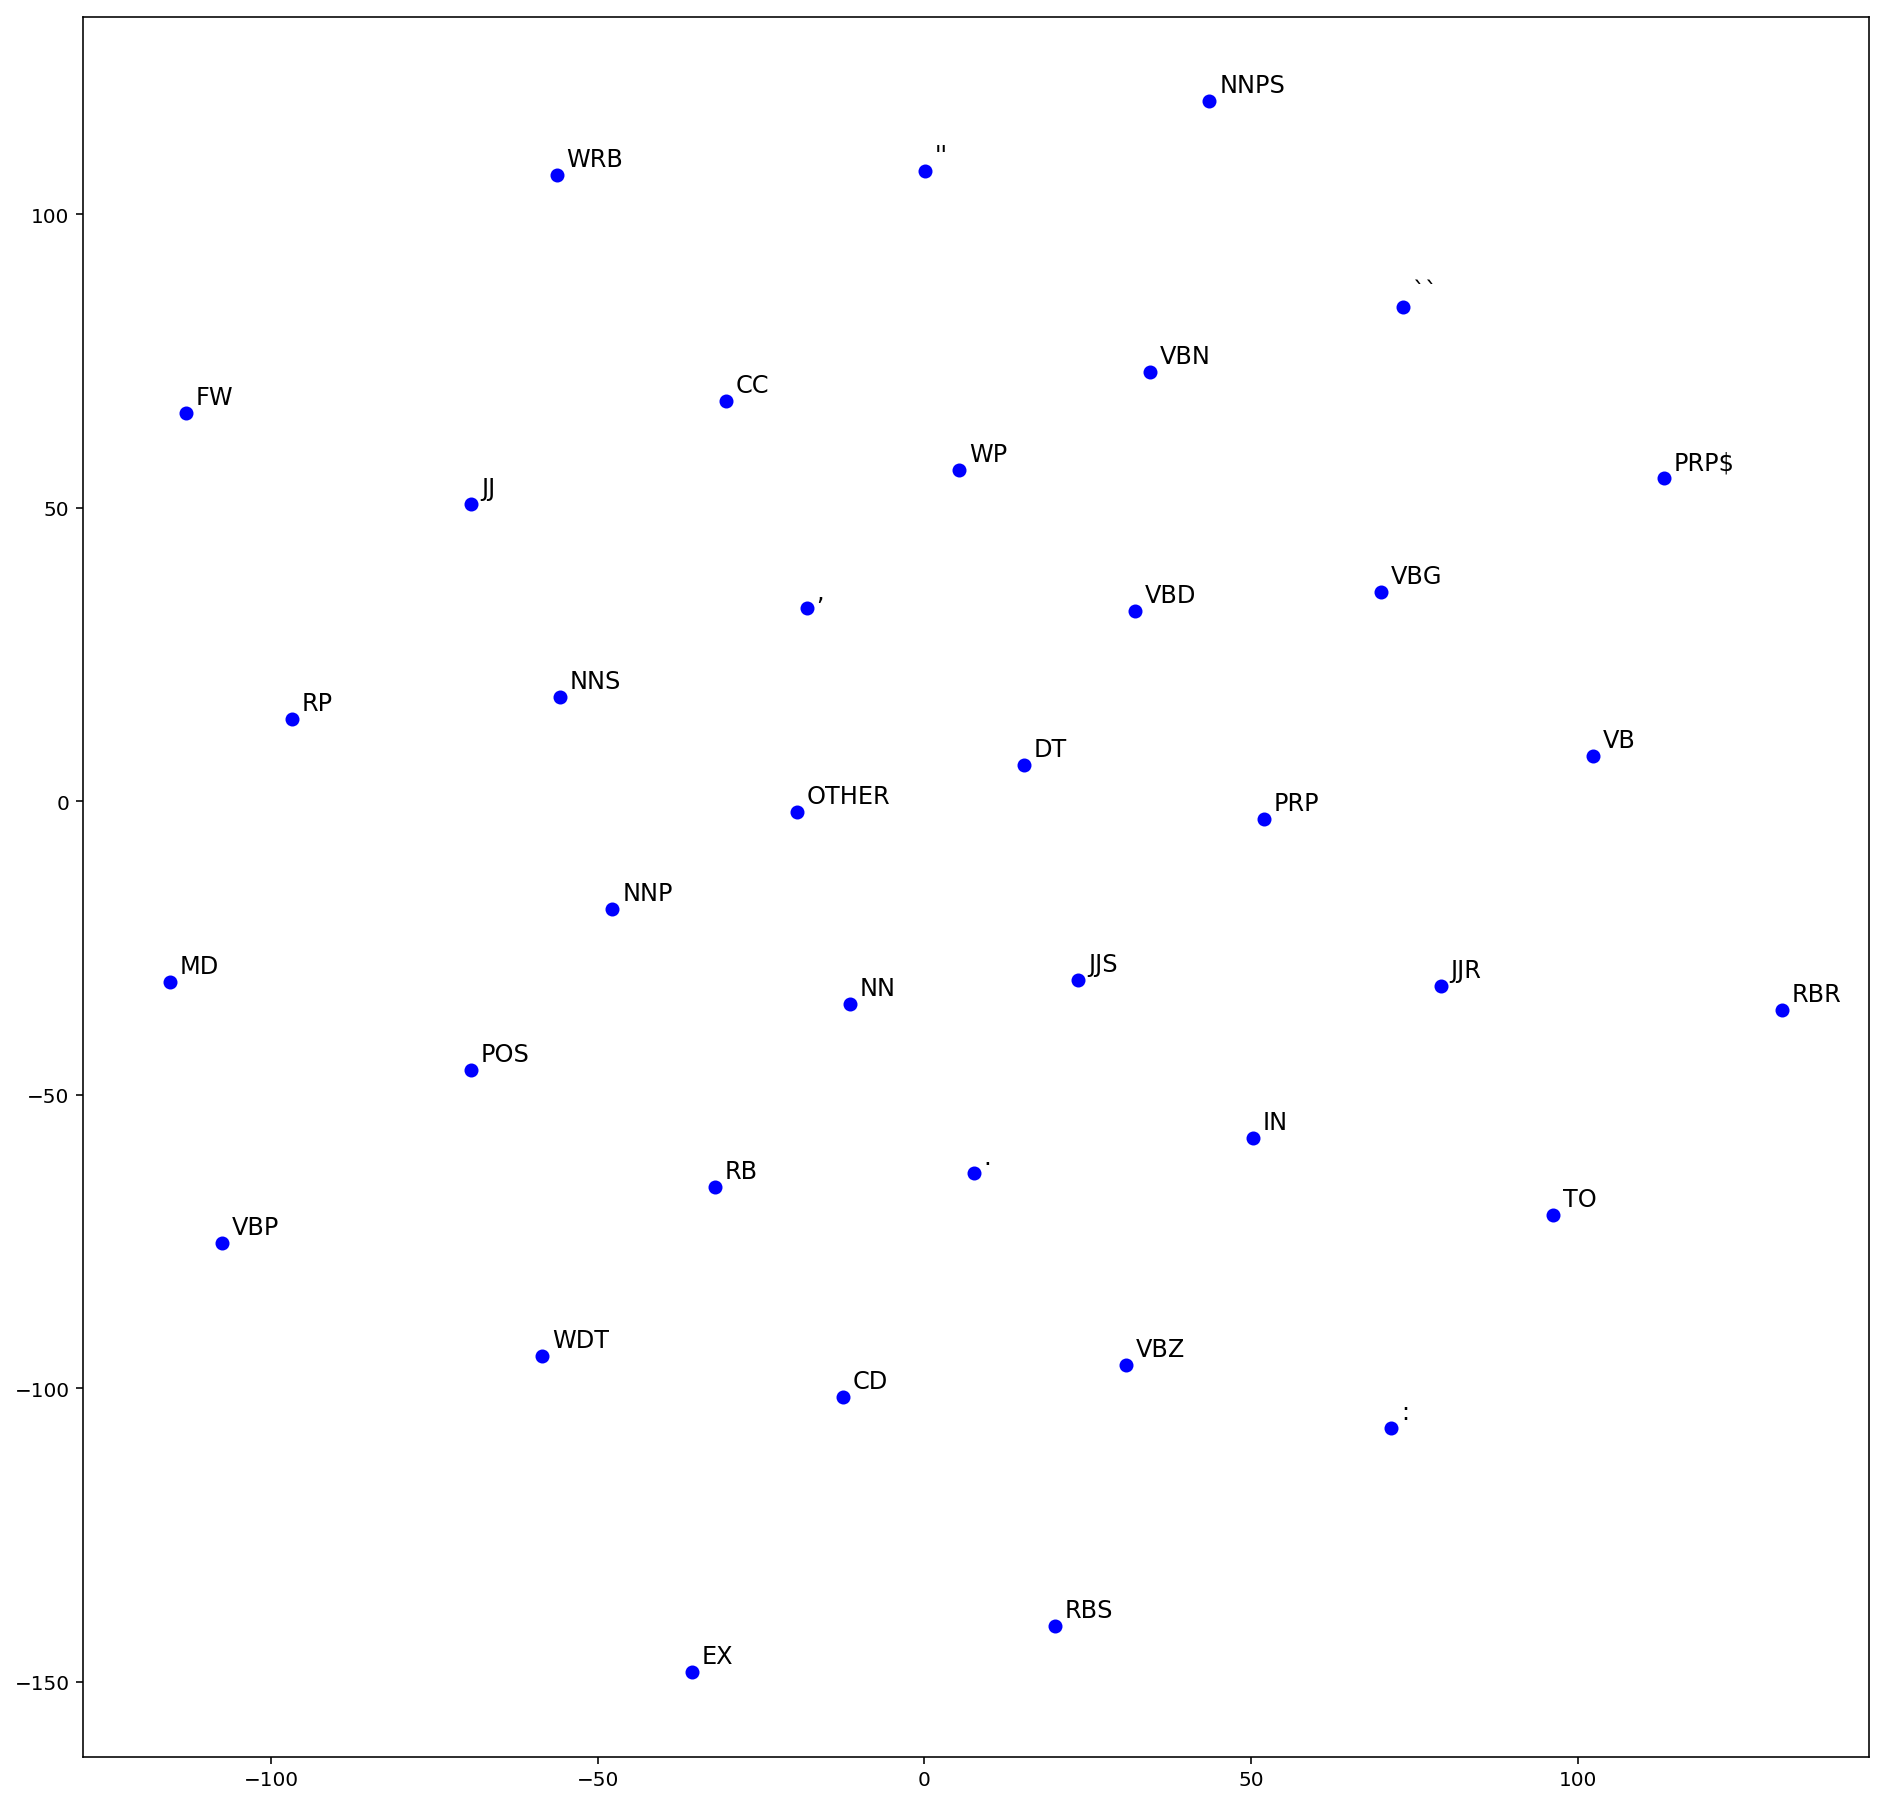

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = n_vocab
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='blue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=1, xytext=(embed_tsne[idx, 0]+1.5, embed_tsne[idx, 1]+1.5), fontsize=12)